# Working with Numpy FFT Results: Scaling and Folding

Imports
-------

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys



Create a Test Signal
--------------------
$f_s$ is the sampling frequency, while $f$ is a base frequency for the signal content. We create a signal that contains components at a couple of multiples of this base frequency. Note the amplitudes here since we will be trying to extract those correctly from the FFT later.

In [21]:
fs = 8*4096.0 # Hz
f   = 50.0 # Hz
t = np.arange(0.0, 1.0, 1/fs)
i = 0.1 * np.cos(2 * np.pi * f * t) + np.random.randn(len(t))#+ 2 * np.sin(10 * 2 * np.pi * f * time)
q = 0.1 * np.sin(2 * np.pi * f * t) #+ 2 * np.sin(10 * 2 * np.pi * f * time)

x = i + 1j*q
NORM = np.max(abs(x.real))/0.1
x.real = np.int16(x.real/(NORM) * (2**15 - 1))
x.imag = np.int16(x.imag/np.max(abs(x.imag)) * (2**15 - 1))
print(x)
print(len(x))


[ -958.  +0.j  -703.+314.j  1214.+628.j ...,  -866.-942.j  -144.-628.j
 -1056.-314.j]
32768


Text(0,0.5,'x')

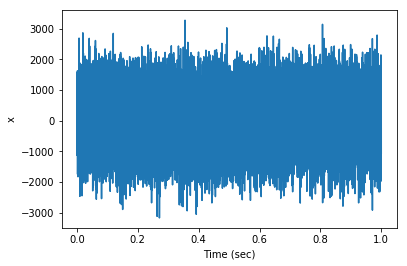

In [22]:
plt.plot(t, x)
plt.xlabel("Time (sec)")
plt.ylabel("x")

In [23]:
from pynq import Overlay

#ol = Overlay('./iotSDR_GPS.bit')
ol = Overlay('../bitstream/iotSDR_GPS_Receiver.bit')
#ol = Overlay('../bitstream/iotSDR_GPS_Receiver32k.bit')


list(ol.ip_dict.keys())

fft_data = ol.fft_data_accelerator.axi_dma_data_fft
fft_config = ol.fft_data_accelerator.axi_dma_fft_config


In [24]:
IP_BASE_ADDRESS = 0x41210000
ADDRESS_RANGE = 0x1000
ADDRESS_OFFSET = 0x10

from pynq import MMIO
mmio = MMIO(IP_BASE_ADDRESS, ADDRESS_RANGE)

#data = 0x00000000
#mmio.write(ADDRESS_OFFSET, data)
result = mmio.read(ADDRESS_OFFSET)
print(hex(result))

0x0


In [25]:
import iotSDR_GPS_streamer as iotSDR_GPS_streamer
import max2769_driver as max2769_driver

wordsPerBlk    = 2*15
gps_chip = max2769_driver.MAX2769()
gps_chip.gps_4096IF_config()

gps_pl   = iotSDR_GPS_streamer.GPS_RX_Streaming(wordsPerBlk,overlay=ol)


GPS chip is configured for IF=0MHz @ 4.096MSPS
GPS chip is configured for IF=4.0960MHz @ 16.368MSPS


In [26]:
from pynq import Xlnk
import numpy as np

xlnk = Xlnk()


def get_config_value(forwards, scaling_sched):
    val = 0
    for scaling in scaling_sched:     # [14:1] = scaling schedule
        val = (val << 2) + scaling
        
    print(hex(val))
    return (val << 1) + int(forwards) # [0] = direction

def fft_config_update(forwards):
    if forwards:
        #config_value = get_config_value(forwards, [1,2, 2, 2, 2, 2, 2, 2])
        config_value = get_config_value(forwards, [1,2, 2, 2, 2, 2, 2, 2])

    else:
        config_value = get_config_value(forwards, [0,0, 0, 0, 0, 0, 0, 0])
  
    fft_buffer_config = xlnk.cma_array(shape=(1,),dtype=np.int32)
    fft_buffer_config[0] = config_value
    fft_config.sendchannel.transfer(fft_buffer_config)
    fft_config.sendchannel.wait()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  after removing the cwd from sys.path.


Compute the FFT
---------------
The FFT and a matching vector of frequencies

In [27]:
def interleave_iq(signal):
    print(signal)
    sig = np.copy(signal)
    i = np.array(sig.real,np.int16)
    q = np.array(sig.imag,np.int16)
    iq = np.concatenate([i,q])
    iq[::2] = i
    iq[1::2] = q
    print((i[0]))

    return iq

def deinterleave_iq(signal):
    return signal[0::2]+1j*signal[1::2]
      

import time
def fft_hw(signal, NFFT):
    
    fft_in_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    fft_out_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    
    fft_out = np.zeros(len(fft_out_buffer))
    
    #for i in range(0,max_iters):
        #tic = time.time()
    np.copyto(fft_in_buffer,signal[NFFT*0:2*(NFFT*(0+1))])
    tic = time.time()
    fft_data.sendchannel.transfer(fft_in_buffer)
    fft_data.recvchannel.transfer(fft_out_buffer)

    fft_data.sendchannel.wait()
    fft_data.recvchannel.wait()
    toc = time.time()
    fft_out = np.array(fft_out_buffer)
    print("fft loopback:",fft_out_buffer)
    print("fft loopback:",fft_out)

    
    delta =  "{:.20f}".format((toc-tic)*1000000)
    print("FFT Time(uSec):", delta)
    fft_out_buffer.close()
    fft_in_buffer.close()
    
    return fft_out

def fft_samples(NFFT):
    
    #fft_in_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    fft_out_buffer = xlnk.cma_array(shape=(NFFT*2,),dtype=np.int16)
    
    fft_out = np.zeros(len(fft_out_buffer))
    
    #for i in range(0,max_iters):
        #tic = time.time()
    #np.copyto(fft_in_buffer,signal[NFFT*0:2*(NFFT*(0+1))])
    tic = time.time()
    #fft_data.sendchannel.transfer(fft_in_buffer)
    fft_data.recvchannel.transfer(fft_out_buffer)

    #fft_data.sendchannel.wait()
    fft_data.recvchannel.wait()
    toc = time.time()
    fft_out = np.array(fft_out_buffer)
    print("fft_out",fft_out)
    
    delta =  "{:.20f}".format((toc-tic)*1000000)
    print("FFT Time(uSec):", delta)
    fft_out_buffer.close()
    #fft_in_buffer.close()
    
    return fft_out    

In [28]:
NFFT = 2**15

# only perform FFT over small subset of data
sig_fft_i = interleave_iq(x)
fft_config_update(True)

[ -958.  +0.j  -703.+314.j  1214.+628.j ...,  -866.-942.j  -144.-628.j
 -1056.-314.j]
-958
0x6aaa


In [35]:

sig_fft_frd = fft_hw(sig_fft_i,NFFT)
#sig_fft_frd = fft_samples(NFFT)

sig_fft_frd

fft loopback: [-15929      0 -26993 ...,  28888  22322 -32475]
fft loopback: [-15929      0 -26993 ...,  28888  22322 -32475]
FFT Time(uSec): 1180.17196655273437500000


array([-15929,      0, -26993, ...,  28888,  22322, -32475], dtype=int16)

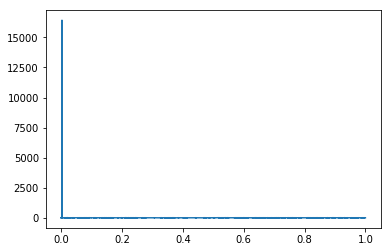

In [30]:
plt.plot(t[:], sig_fft_frd.real[:NFFT])


In [31]:
gps_pl.select_iq_for_fft(0)
print(sig_fft_frd)
fft_config_update(False)
sig_fft_inv = fft_hw(sig_fft_frd,NFFT)
sig_fft_c = deinterleave_iq(sig_fft_inv)
sig_fft_c

[ 4  0  0 ..., -6 -1  0]
0x0
fft loopback: [-1182   -70  -667 ...,  -563 -1013  -364]
fft loopback: [-1182   -70  -667 ...,  -563 -1013  -364]
FFT Time(uSec): 1220.70312500000000000000


array([-1182. -70.j,  -667.+220.j,  1384.+654.j, ...,  -917.-987.j,
        -228.-563.j, -1013.-364.j])

Text(0,0.5,'x')

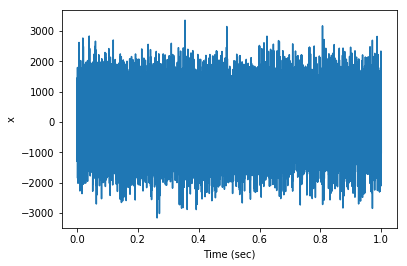

In [32]:
plt.plot(t, sig_fft_c.real)
plt.xlabel("Time (sec)")
plt.ylabel("x")


In [14]:

fft_x = np.fft.fft(x)
fft_i = np.fft.ifft(fft_x)

n = len(fft_x)
print(n)
#plt.plot(np.abs(fft_x))

32768


/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0,0.5,'x')

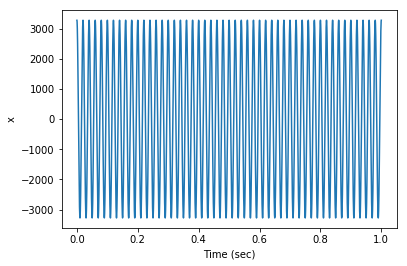

In [15]:
plt.plot(t, fft_i)
plt.xlabel("Time (sec)")
plt.ylabel("x")

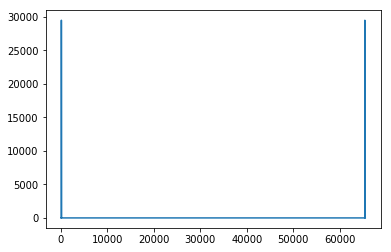

In [16]:
plt.plot(np.abs(sig_fft_frd))

Swap Half Spaces
----------------
Note that frequencies in the FFT and the `freq` vector go from zero to some larger positive number then from a large negative number back toward zero. We can swap that so that the DC component is in the center of the vector while maintaining a two-sided spectrum.

In [20]:
freq = np.fft.fftfreq(n, 1/fs)

fft_x_shifted = np.fft.fftshift(sig_fft_frd)
freq_shifted = np.fft.fftshift(freq)
freq

array([ 0.,  1.,  2., ..., -3., -2., -1.])

ValueError: x and y must have same first dimension, but have shapes (32768,) and (65536,)

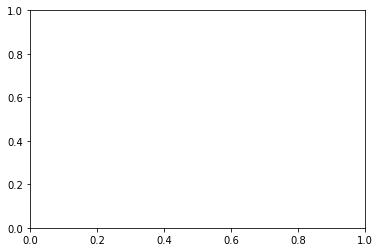

In [18]:
plt.plot(freq_shifted, np.abs(fft_x_shifted))
plt.xlabel("Frequency (Hz)")

Fold Negative Frequencies and Scale
------------------------------
It's actually more common to look at just the first half of the unshifted FFT and frequency vectors and fold all the amplitude information into the positive frequencies. Furthermore, to get ampltude right, we must normalize by the length of the original FFT. Note the factor of $2/n$ in the following which accomplishes both the folding and scaling.

Now the spectrum contains spikes at the correct amplitudes at only positive frequencies, which are the only ones with physicality.